# German Credit Card Fraud Detection(Sayandeep Dey)

## Overview
- You will perform credit risk prediction for loan applicants using the German Credit dataset in a Google Colaboratory notebook.
- The dataset includes:
  - Financial history
  - Personal information
  - Loan-related features

## Rules
- The objective is to predict whether a loan applicant poses a **good** or **bad** credit risk.
- There are no restrictions on the machine learning methods used, provided they are available in the Google Colaboratory free-tier environment.
- You may use external libraries (e.g., `sklearn`, `xgboost`, `shap`) for model development and analysis.
  - If using additional libraries, include the necessary installation commands in the notebook (e.g., `!pip install xgboost`).

## Required Deliverables
Use both code and Markdown as needed to provide the following information:

### Data Exploration and Preprocessing
- Analyze the dataset to understand feature distributions and class balance.
- Handle missing values, outliers, and perform data cleaning.
- Perform feature engineering to create new features that may improve model accuracy.

### Model Development for Credit Risk Prediction
- Justify the choice of machine learning algorithm(s).
- Describe the approach used for training, validation, and hyperparameter tuning.
- Explain any hypotheses regarding feature selection or model structure.

### Evaluation of Classification Performance Using Actual Labels
- Select and justify appropriate evaluation metrics (e.g., accuracy, precision, recall, F1-score, ROC-AUC).
- Provide visualizations of model performance (e.g., confusion matrix, ROC curve).

### Model Interpretation and Insights
- Identify and interpret key features influencing the model's predictions.
- Use visualization tools (e.g., SHAP, feature importance plots) to communicate findings.
- Summarize practical insights for improving the credit evaluation process.

### Error Analysis and Model Challenges
- Analyze misclassifications and potential causes.
- Discuss any data quality or modeling limitations identified.

### Hypotheses for Accuracy Improvement
- Propose strategies to enhance model performance (e.g., more granular data, better feature selection, ensemble methods).

### Expected Benefits of Model Deployment
- Discuss how deploying this model can reduce financial risk, improve loan approval accuracy, and enhance customer trust.

# Importing important libraries

In [1]:
# Try importing pandas; if not installed, install it

try:
    import matplotlib.pyplot as plt
except ImportError:
    !pip install matplotlib
    import matplotlib.pyplot as plt

try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    !pip install imbalanced-learn
    from imblearn.over_sampling import SMOTE

try:
    import pandas as pd
except ImportError:
    !pip install pandas
    import pandas as pd

# Try importing numpy; if not installed, install it
try:
    import numpy as np
except ImportError:
    !pip install numpy
    import numpy as np

# Try importing lightgbm; if not installed, install it
try:
    import lightgbm as lgb
except ImportError:
    !pip install lightgbm
    import lightgbm as lgb

# Try importing Prophet from prophet; if not installed, install it
try:
    from prophet import Prophet
except ImportError:
    !pip install prophet
    from prophet import Prophet

# Try importing xgboost; if not installed, install it
try:
    import xgboost as xgb
except ImportError:
    !pip install xgboost
    import xgboost as xgb

# Try importing important sub-modules from sklearn; if not installed, install scikit-learn
try:
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    from sklearn.metrics import mean_absolute_percentage_error as mape
    from sklearn.model_selection import GridSearchCV
    from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
except ImportError:
    !pip install scikit-learn
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    from sklearn.metrics import mean_absolute_percentage_error as mape
    from sklearn.model_selection import GridSearchCV
    from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

# math is part of the Python standard library
import math


/home/sayanlol/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load and preprocess data
**Data Preprocessing Adjustments:**

- **Actual Performance Column Fix:**  
  The `actual_performance` column was not imported correctly due to a naming split. We resolved this by renaming the column to `'actual_performance(10,000 kW)'` and dropping the erroneous fragment.

- **Weather Data Aggregation:**  
  To create unified weather features, we aggregated temperature, precipitation, and humidity across all cities by taking the mean for each row.

In [2]:
import os
print(os.getcwd())
data = pd.read_csv('german_credit_data.csv')
data.head()

/mnt/c/ProgrammingInGeneral/ML/TempTask3


,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


# Lag and rolling features

In [3]:
# Calculate the split point for 90% training and 10% testing
split_index = int(len(data) * 0.9)

# Split the data into training and testing sets
train = data.iloc[:split_index]  # First 90% for training
test = data.iloc[split_index:]   # Last 10% for testing
train.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [4]:
# Select features (all columns except 'Risk') and target ('Risk') for training and testing
from pydash import drop


# Select features (all columns except 'Risk') and target ('Risk') for training and testing
X_train, y_train = train.drop(columns=['Risk']), train['Risk']
X_test, y_test = test.drop(columns=['Risk']), test['Risk']

# Map target variable to numeric values
y_train = y_train.map({'bad': 0, 'good': 1})
y_test = y_test.map({'bad': 0, 'good': 1})

# One-hot encode categorical features
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Align columns in training and testing sets
X_train, X_test = X_train.align(X_test, join='left', axis=1)
X_test = X_test.fillna(0)

# Correctly modify column names without overwriting the DataFrame
X_train.columns = X_train.columns.str.replace('[:]', '', regex=True)
X_test.columns = X_test.columns.str.replace('[:]', '', regex=True)

# Correctting imbalanced dataset
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Print shapes to verify
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

Shape of X_train: (1264, 20)
Shape of y_train: (1264,)


# LightGBM
**Model Choice Justification:**
LightGBM was selected for its superior handling of:
- Temporal patterns through lag features
- Non-linear relationships 
- Feature interactions 


Accuracy: 0.70
Precision: 0.75
Recall: 0.84
F1-Score: 0.79
ROC-AUC: 0.65


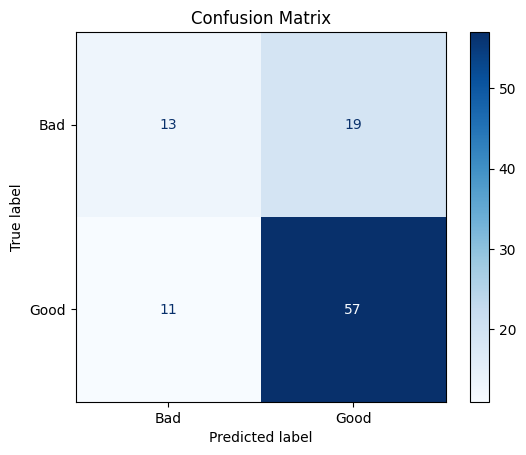

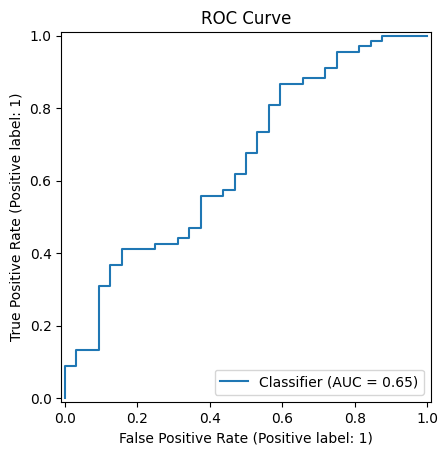

In [5]:
from tabnanny import verbose


lgb_params = {
    'num_leaves': [31, 63],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_data_in_leaf': [20, 50],
    'bagging_fraction': [0.8, 0.9],
    'feature_fraction': [0.8, 0.9],
    'n_estimators': [100,200, 300],
	'verbose': [-1] 
}

lgb_model = lgb.LGBMRegressor(random_state=42,verbose=-1)
grid_search = GridSearchCV(lgb_model, lgb_params, cv=3, scoring='neg_mean_absolute_error')


grid_search.fit(X_train, y_train)

model = grid_search.best_estimator_

preds = model.predict(X_test)
y_pred = (preds > 0.6).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, preds)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Bad', 'Good'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
RocCurveDisplay.from_predictions(y_test, preds)
plt.title("ROC Curve")
plt.show()

# Random Forest
**Model Choice Justification:**
Random Forest was included to:
- Provide a robust, ensemble-based approach that reduces variance through bagging.
- Capture non-linear relationships with minimal hyperparameter tuning.
- Offer resilience to outliers and noisy data, serving as a strong baseline model.

**Feature Limitations:**
- Tends to average predictions, which can smooth out fine-grained temporal fluctuations.
- Has limited capability to extrapolate trends beyond the training data range.
- May require a large number of trees or additional feature engineering to accurately model sub-daily patterns.

Random Forest - Accuracy: 0.71
Random Forest - Precision: 0.76
Random Forest - Recall: 0.84
Random Forest - F1-Score: 0.80
Random Forest - ROC-AUC: 0.64


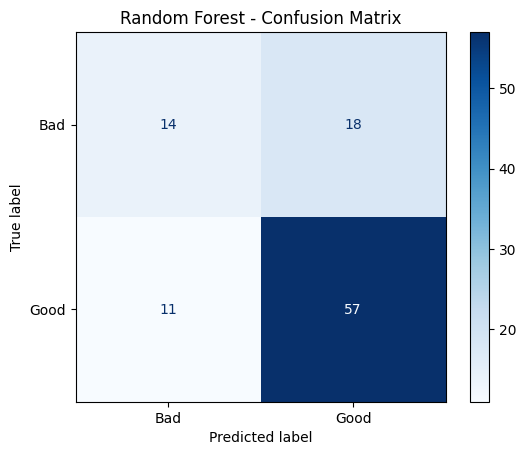

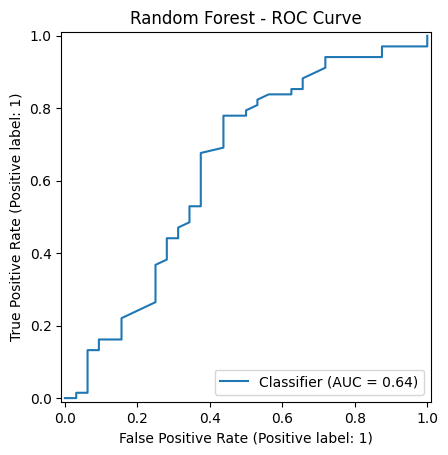

In [6]:
# Define hyperparameters
rf_params = {
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 0.8],
    'min_samples_split': [2, 5],
    'n_estimators': [100,200, 300]
}

# Initialize model
rf_model = RandomForestClassifier(random_state=42)

# Grid search with cross-validation
grid_search = GridSearchCV(rf_model, rf_params, cv=3, scoring='f1')
grid_search.fit(X_train, y_train)

# Best model
best_rf_model = grid_search.best_estimator_

# Predict probabilities and class labels
rf_preds_prob = best_rf_model.predict_proba(X_test)[:, 1]
rf_preds = (rf_preds_prob > 0.55).astype(int)

# Evaluation Metrics
accuracy = accuracy_score(y_test, rf_preds)
precision = precision_score(y_test, rf_preds)
recall = recall_score(y_test, rf_preds)
f1 = f1_score(y_test, rf_preds)
roc_auc = roc_auc_score(y_test, rf_preds_prob)

# Print metrics
print(f"Random Forest - Accuracy: {accuracy:.2f}")
print(f"Random Forest - Precision: {precision:.2f}")
print(f"Random Forest - Recall: {recall:.2f}")
print(f"Random Forest - F1-Score: {f1:.2f}")
print(f"Random Forest - ROC-AUC: {roc_auc:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, rf_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Bad', 'Good'])
disp.plot(cmap='Blues')
plt.title("Random Forest - Confusion Matrix")
plt.show()

# ROC Curve
RocCurveDisplay.from_predictions(y_test, rf_preds_prob)
plt.title("Random Forest - ROC Curve")
plt.show()

# XGBoost
**Model Choice Justification:**

XGBoost was included to:
- Efficiently capture complex non-linear interactions through gradient boosting.
- Benefit from built-in regularization (L1 & L2) to help prevent overfitting.
- Automatically rank feature importance, aiding in interpretability and further feature engineering.

**Feature Limitations:**
- Performance is highly sensitive to hyperparameter tuning, requiring careful optimization.
- May require significant preprocessing to handle noisy or missing data effectively.
- Does not inherently capture temporal dependencies, necessitating engineered lag features or time-based variables.

XGBoost - Accuracy: 0.70
XGBoost - Precision: 0.71
XGBoost - Recall: 0.96
XGBoost - F1-Score: 0.81
XGBoost - ROC-AUC: 0.65


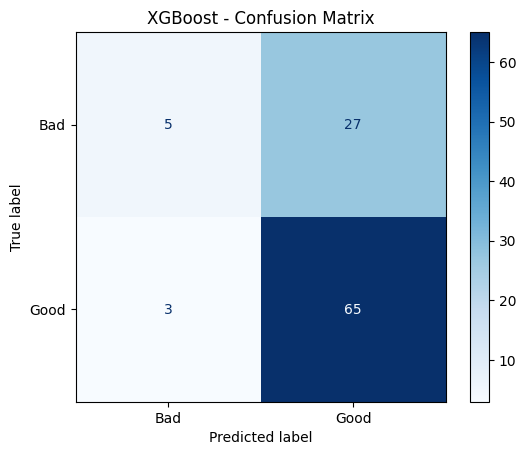

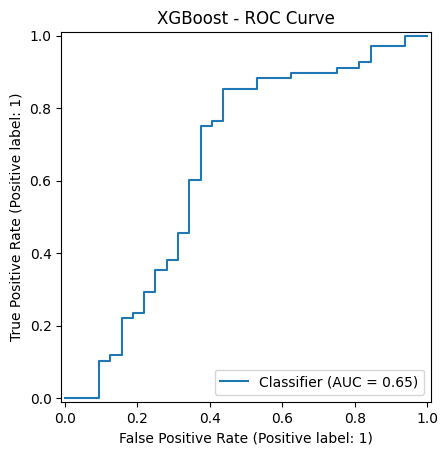

In [7]:
# XGBoost parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'n_estimators': [100,200, 300]
}

# Initialize XGBClassifier
xxgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')

# Grid Search CV
grid_search = GridSearchCV(xxgb_model, param_grid, cv=3, scoring='f1')
grid_search.fit(X_train, y_train)

# Best model
xgb_model = grid_search.best_estimator_

# Predict probabilities and labels
xgb_preds_prob = xgb_model.predict_proba(X_test)[:, 1]
xgb_preds = (xgb_preds_prob > 0.5).astype(int)

# Evaluation Metrics
accuracy = accuracy_score(y_test, xgb_preds)
precision = precision_score(y_test, xgb_preds)
recall = recall_score(y_test, xgb_preds)
f1 = f1_score(y_test, xgb_preds)
roc_auc = roc_auc_score(y_test, xgb_preds_prob)

# Print metrics
print(f"XGBoost - Accuracy: {accuracy:.2f}")
print(f"XGBoost - Precision: {precision:.2f}")
print(f"XGBoost - Recall: {recall:.2f}")
print(f"XGBoost - F1-Score: {f1:.2f}")
print(f"XGBoost - ROC-AUC: {roc_auc:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, xgb_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Bad', 'Good'])
disp.plot(cmap='Blues')
plt.title("XGBoost - Confusion Matrix")
plt.show()

# ROC Curve
RocCurveDisplay.from_predictions(y_test, xgb_preds_prob)
plt.title("XGBoost - ROC Curve")
plt.show()

### **GBM (Gradient Boosting Machine)**  
**Model Choice Justification:**

GBM was included to:  
- Leverage sequential ensemble learning, where each tree corrects the errors of the previous one, improving overall model performance.  
- Provide a flexible framework that can be fine-tuned for bias-variance tradeoff using parameters like `learning_rate`, `max_depth`, and `subsample`.  
- Offer robustness to overfitting when used with shallow trees and appropriate regularization.

**Feature Limitations:**  
- Generally slower to train than newer algorithms like XGBoost or LightGBM, especially on large datasets.  
- Lacks native support for parallel training, leading to longer optimization cycles.  
- Sensitive to noisy data and outliers unless adequately regularized or preprocessed.

GBM - Accuracy: 0.70
GBM - Precision: 0.73
GBM - Recall: 0.88
GBM - F1-Score: 0.80
GBM - ROC-AUC: 0.63


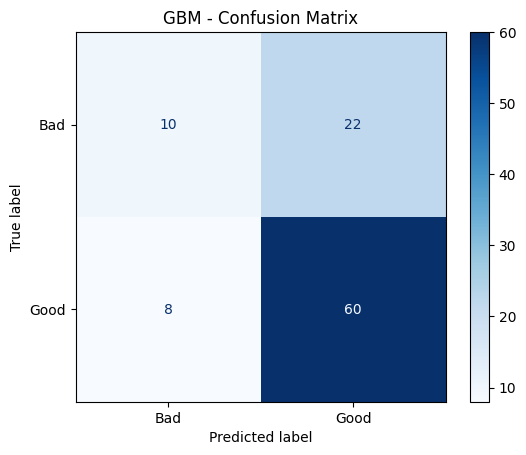

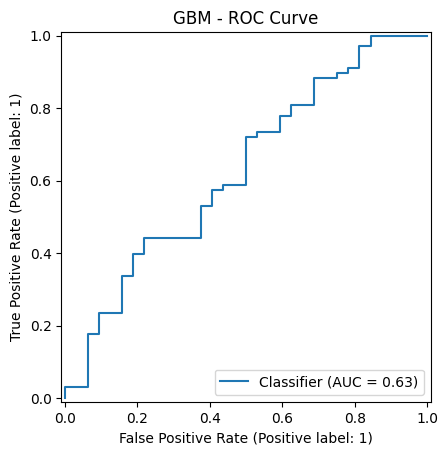

In [8]:
# Define hyperparameters
gbm_params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200,300],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', 'log2']
}

# Instantiate model
gbm_model = GradientBoostingClassifier(random_state=42)

# Grid search with 3-fold CV
grid_search = GridSearchCV(gbm_model, gbm_params, cv=3, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Best model
best_gbm_model = grid_search.best_estimator_

# Predict probabilities and classes
gbm_preds_prob = best_gbm_model.predict_proba(X_test)[:, 1]
gbm_preds = (gbm_preds_prob > 0.6).astype(int)

# Evaluation metrics
accuracy = accuracy_score(y_test, gbm_preds)
precision = precision_score(y_test, gbm_preds)
recall = recall_score(y_test, gbm_preds)
f1 = f1_score(y_test, gbm_preds)
roc_auc = roc_auc_score(y_test, gbm_preds_prob)

# Print metrics
print(f"GBM - Accuracy: {accuracy:.2f}")
print(f"GBM - Precision: {precision:.2f}")
print(f"GBM - Recall: {recall:.2f}")
print(f"GBM - F1-Score: {f1:.2f}")
print(f"GBM - ROC-AUC: {roc_auc:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, gbm_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Bad', 'Good'])
disp.plot(cmap='Blues')
plt.title("GBM - Confusion Matrix")
plt.show()

# ROC Curve
RocCurveDisplay.from_predictions(y_test, gbm_preds_prob)
plt.title("GBM - ROC Curve")
plt.show()